In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
BASE_PATH ='/home/amirh/code/local_explanations_whitebox/tabular/data'
import joblib
from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)

In [89]:
from sklearn.base import TransformerMixin
import scipy
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if type(X) == scipy.sparse.csr.csr_matrix:    
            return X.todense()
        else: 
            return X

In [90]:
#measures = pickle.load( open( "{}/exp_accuracy_v10.p".format(BASE_PATH), "rb" ) )
measures = pickle.load( open( "{}/exp_accuracy_v10_new.p".format(BASE_PATH), "rb" ) )
data_info = pickle.load(open("{}/data_info_v2.p".format(BASE_PATH), "rb"))

In [91]:
measures['robust']['lreg'].keys()

dict_keys(['lime', 'shap', 'lpi'])

In [106]:
lreg_corr = np.load('./lreg_corr.npy')
gbayes_corr = np.load('./gbayes_corr.npy')

In [93]:
models = ['lreg', 'gbayes']

In [94]:
datasets = ['hattrick', 'breast_cancer', 'pima_indians', 'banknote', 'iris', 
   'haberman', 'spambase', 'titanic', 'heart_disease', 'churn', 
                 'hr', 'audit', 'loan', 'attrition', 'donor', 'seismic', 'thera', 'adult', 'insurance', 'banking']  
dataset_names =  ['Hattrick', 'Breast Cancer', 'Pima Indians', 'Banknote', 'Iris', 
    'Haberman', 'Spambase', 'Titanic', 'Heart Disease', 'Churn', 
                'Hr', 'Audit', 'Loan', 'Attrition', 
                'Donor', 'Seismic', 'Thera', 'Adult', 'Insurance', 'Banking']      


In [8]:
#datasets =  [ 'breast_cancer', 'pima_indians', 'banknote', 'iris', 
#    'haberman', 'spambase', 'titanic', 'heart_disease', 'churn', 
#                 'hr', 'audit', 'loan', 'attrition', 
#                'donor', 'seismic', 'thera', 'adult', 'insurance', 'banking']  
#dataset_names =  [ 'Breast Cancer', 'Pima Indians', 'Banknote', 'Iris', 
#    'Haberman', 'Spambase', 'Titanic', 'Heart Disease', 'Churn', 
#                 'Hr', 'Audit', 'Loan', 'Attrition', 
#                'Donor', 'Seismic', 'Thera', 'Adult', 'Insurance', 'Banking']  

In [120]:
def get_corr(model):
    inner_corr = []
    for data_key in datasets: 
        x_train = np.load('{}/{}/{}/x_train.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)
        model_object = joblib.load('{}/{}/{}/{}_v1.joblib'.format(BASE_PATH, data_key, preproc, model))

        x_train_transformed = model_object['to_dense'].transform(x_train)

        corr_matrix = np.corrcoef(x_train_transformed, rowvar=False)
        corr_matrix[np.tril_indices(corr_matrix.shape[0])] = np.nan
        #corr_feat_nums = (corr_matrix > 0.95).sum()
        corr_feat_nums = (corr_matrix > 0.7).sum()
        tot_feat = (x_train_transformed.shape[1] * (x_train_transformed.shape[1] - 1))

        #inner_corr.append( corr_feat_nums/ tot_feat )
        inner_corr.append( corr_feat_nums)
    return inner_corr

In [96]:
#preproc = 'standard'
#model = 'lreg'
#inner_corr = []

#np.save('./inner_corr.npy', inner_corr)

/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning

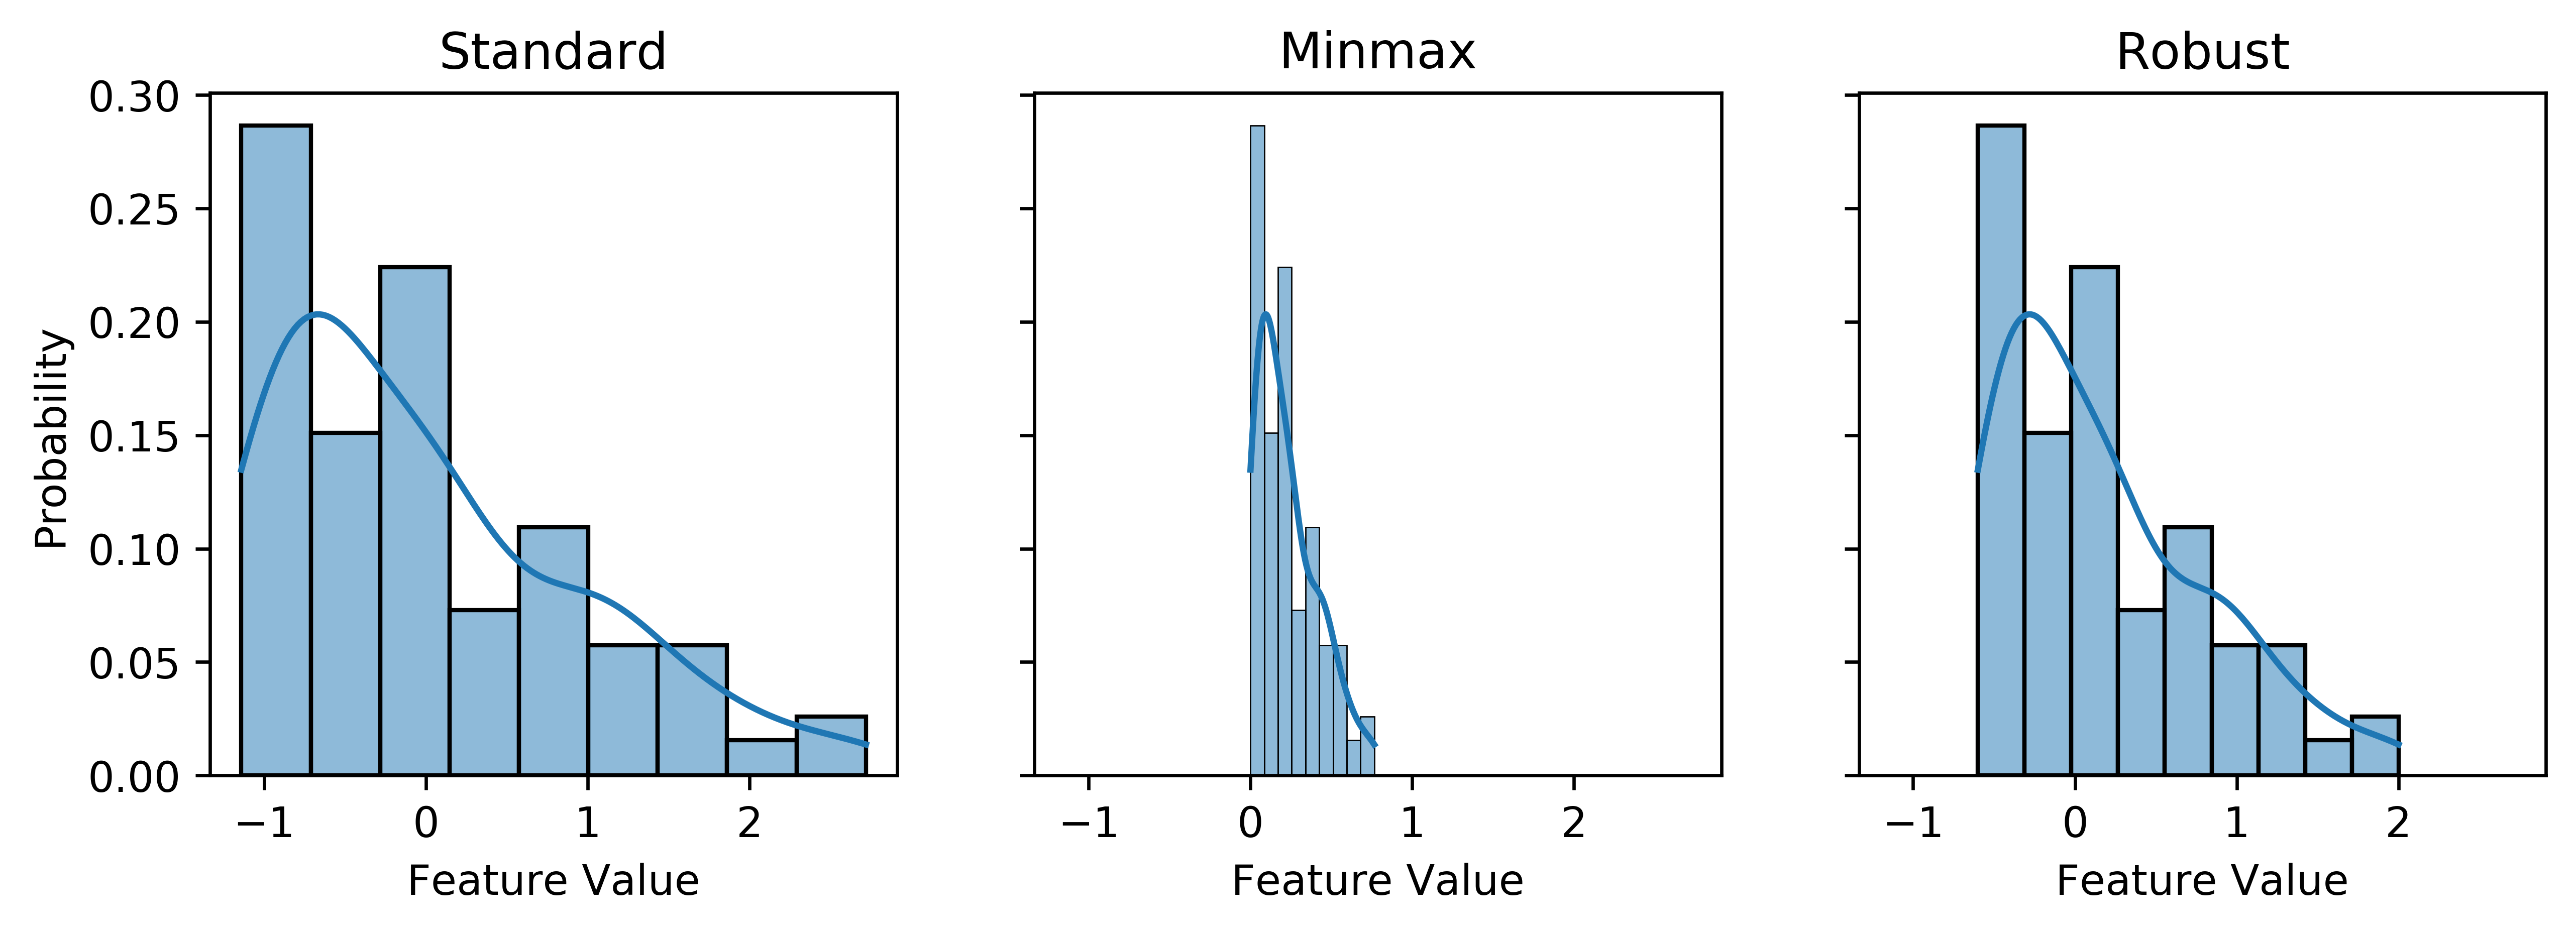

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=600, sharex=True, sharey=True)
feat_id = 0
data_key = 'pima_indians'
all_preproc = ['standard', 'minmax', 'robust']
all_preproc_name = ['Standard', 'Minmax', 'Robust']
for i in range(len(all_preproc)):
    x_test = np.load('{}/{}/{}/x_test.npy'.format(BASE_PATH, data_key, all_preproc[i]),  allow_pickle=True)
    #ax[i].hist(x_test[:, feat_id], density=True)
    ax[i].set_title(all_preproc_name[i])
    ax[i].set_xlabel('Feature Value')
    sns.histplot(x_test[:, feat_id], ax=ax[i], stat='probability', kde=True)
plt.savefig('preprocessing_viz.pdf')

In [97]:
from sklearn.metrics import accuracy_score

model_perf = {}
for preproc in ['standard', 'minmax', 'robust']:
    model_perf[preproc] = {}
    for model in models:
        model_perf[preproc][model] = []
        for data_key in datasets: 
            x_test = np.load('{}/{}/{}/x_test.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)
            y_test = np.load('{}/{}/{}/y_test.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)

            model_object = joblib.load('{}/{}/{}/{}_v1.joblib'.format(BASE_PATH, data_key, preproc, model))

            x_test_transformed = model_object['to_dense'].transform(x_test)
            pred = model_object.predict(x_test_transformed)

            model_perf[preproc][model] .append(accuracy_score(y_test, pred))

/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/home/amirh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature n

In [121]:
data_feat_len = []
data_cat_feat_len = []
data_tot_feat = []
for d in datasets:
    tot_feat = len(data_info[d]['features'])
    cat_feat = len(data_info[d]['cat_feature_name'])
    data_tot_feat.append(tot_feat)
    #data_feat_len.append((tot_feat - cat_feat) /tot_feat)
    #data_cat_feat_len.append(cat_feat /tot_feat)
    data_feat_len.append((tot_feat - cat_feat) )
    data_cat_feat_len.append(cat_feat )

In [122]:
info = pd.DataFrame([data_feat_len, data_cat_feat_len, data_tot_feat]).T
info.index = dataset_names
info.iloc[:, 0:3].astype(np.int32)
info['LR'] = model_perf['standard']['lreg']
info['NB'] = model_perf['standard']['gbayes']

In [123]:
print(tabulate(info.round(2).sort_index(), tablefmt="latex_raw"))

\begin{tabular}{lrrrrr}
\hline
 Adult         &  6 &  8 & 14 & 0.85 & 0.56 \\
 Attrition     & 16 & 17 & 33 & 1    & 1    \\
 Audit         & 23 &  3 & 26 & 0.99 & 0.96 \\
 Banking       &  5 & 10 & 15 & 0.91 & 0.83 \\
 Banknote      &  4 &  0 &  4 & 0.98 & 0.85 \\
 Breast Cancer & 30 &  0 & 30 & 0.97 & 0.92 \\
 Churn         &  8 &  2 & 10 & 0.81 & 0.8  \\
 Donor         & 42 &  6 & 48 & 1    & 1    \\
 Haberman      &  3 &  0 &  3 & 0.66 & 0.65 \\
 Hattrick      & 20 &  4 & 24 & 1    & 0.79 \\
 Heart Disease &  6 &  7 & 13 & 0.83 & 0.8  \\
 Hr            &  2 & 10 & 12 & 0.78 & 0.38 \\
 Insurance     &  4 &  6 & 10 & 0.99 & 0.07 \\
 Iris          &  4 &  0 &  4 & 1    & 1    \\
 Loan          &  5 &  8 & 13 & 1    & 1    \\
 Pima Indians  &  8 &  0 &  8 & 0.8  & 0.77 \\
 Seismic       & 14 &  4 & 18 & 0.95 & 0.42 \\
 Spambase      & 58 &  0 & 58 & 0.92 & 0.81 \\
 Thera         & 10 &  2 & 12 & 1    & 1    \\
 Titanic       &  6 &  2 &  8 & 0.79 & 0.79 \\
\hline
\end{tabular}


In [124]:
accuracy_per_preproc = pd.concat([pd.DataFrame([model_perf['standard']['lreg'], model_perf['standard']['gbayes']]),
pd.DataFrame([model_perf['minmax']['lreg'], model_perf['minmax']['gbayes']]),
pd.DataFrame([model_perf['robust']['lreg'], model_perf['robust']['gbayes']])]).T

In [125]:
accuracy_per_preproc.index = dataset_names

In [126]:
print(tabulate(accuracy_per_preproc.round(2).sort_index(), tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 Adult         & 0.85 & 0.56 & 0.85 & 0.55 & 0.85 & 0.58 \\
 Attrition     & 1    & 1    & 1    & 1    & 1    & 1    \\
 Audit         & 0.99 & 0.96 & 0.97 & 0.96 & 0.99 & 0.96 \\
 Banking       & 0.91 & 0.83 & 0.91 & 0.82 & 0.91 & 0.83 \\
 Banknote      & 0.98 & 0.85 & 0.98 & 0.85 & 0.98 & 0.85 \\
 Breast Cancer & 0.97 & 0.92 & 0.97 & 0.92 & 0.97 & 0.92 \\
 Churn         & 0.81 & 0.8  & 0.81 & 0.8  & 0.81 & 0.8  \\
 Donor         & 1    & 1    & 1    & 1    & 1    & 1    \\
 Haberman      & 0.66 & 0.65 & 0.69 & 0.65 & 0.66 & 0.65 \\
 Hattrick      & 1    & 0.79 & 0.99 & 0.79 & 1    & 0.79 \\
 Heart Disease & 0.83 & 0.8  & 0.83 & 0.8  & 0.83 & 0.8  \\
 Hr            & 0.78 & 0.38 & 0.78 & 0.37 & 0.78 & 0.38 \\
 Insurance     & 0.99 & 0.07 & 0.99 & 0.07 & 0.99 & 0.08 \\
 Iris          & 1    & 1    & 1    & 1    & 1    & 1    \\
 Loan          & 1    & 1    & 1    & 0.99 & 1    & 0.99 \\
 Pima Indians  & 0.8  & 0.77 & 0.78 & 0.77 & 0.8  & 0.77 \\
 Seismic

In [127]:
models = ['lreg', 'gbayes']
preprocessing = ['standard', 'robust', 'minmax']
measure_names = ['spearman_abs', 'cosine', 'norm']
exp_models = ['lime', 'shap', 'lpi']

In [128]:
def get_mean_measure(models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    mean_measure = pd.DataFrame()

    for model in models:
        for exp_model in exp_models: 
            _measure = measures[preproc][model][exp_model]
            mean_measure_res = []
            for j in range(len(datasets)):
                #print(_measure[j][measure_name])
                avg_measure = np.nanmean(_measure[j][measure_name])
                mean_measure_res.append(avg_measure)
            mean_measure[model, exp_model] =  mean_measure_res
    mean_measure.index = datasets 
    
    mean_measure.index = dataset_names 
    #mean_measure = mean_measure.sort_index().round(3)
        
    mean_measure['# Features'] = data_feat_len
    mean_measure['# Cat Features'] = data_cat_feat_len
    mean_measure['# Corr. Features'] = get_corr(model_name)
    mean_measure['# Total Features'] = data_tot_feat
    
    for model in models:
        if model == 'lreg':
            mean_measure['# Corr. Features (Output)'] = lreg_corr
            mean_measure['Accuracy'] = model_perf['standard']['lreg']
        else: 
            mean_measure['# Corr. Features (Output)'] = gbayes_corr
            mean_measure['Accuracy'] = model_perf['standard']['gbayes']
    

    mean_measure = mean_measure.sort_index()
    mean_measure.loc['Average'] = mean_measure.mean()
    mean_measure.loc['Standard Deviation'] = mean_measure.std()

    return mean_measure

def get_all_rank_preproc(measure_name):
    all_ranks = []
    for preproc in preprocessing:
        get_mean_spearman = get_mean_measure(models, preproc, ['lime', 'shap', 'lpi'], measure_name)
        all_ranks.append(get_mean_spearman.loc['Average'])
    return pd.DataFrame(all_ranks, index=preprocessing)

def get_all_rank_measure(preproc='standard'):
    all_ranks = []
    for measure in measure_names:
        get_mean_spearman = get_mean_measure(models, preproc, measure_name=measure)
        all_ranks.append(get_mean_spearman.loc['Average'])
    return pd.DataFrame(all_ranks, index=measure_names)

In [116]:
def get_all_rank_measure(preproc='standard'):
    all_ranks = []
    for measure in measure_names:
        get_mean_spearman = get_mean_measure(models, preproc, measure_name=measure)
        all_ranks.append(get_mean_spearman.loc['Average'])
    return pd.DataFrame(all_ranks, index=measure_names)

In [56]:
print(tabulate(get_all_rank_measure(preproc='standard').round(3).iloc[:, 0:6], tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 spearman_abs & 0.258 & 0.212 & 0.237 & 0.137 & 0.228 & 0.115 \\
 cosine       & 0.008 & 0.036 & 0.253 & 0.012 & 0.031 & 0.198 \\
 norm         & 0.495 & 0.503 & 0.484 & 0.228 & 0.264 & 0.256 \\
\hline
\end{tabular}


In [129]:
model_name = 'lreg'
m_spearman = get_mean_measure([model_name],  'standard', ['lime', 'shap', 'lpi'],measure_name='spearman_abs')
m_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Corr. Feat', 'Total Features', '# Corr. Feat (Output)', 'Accuracy']

In [130]:
m_spearman_g = get_mean_measure(['gbayes'],  'standard', ['lime', 'shap', 'lpi'],measure_name='spearman_abs')
m_spearman_g.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Total Feat', '# Corr. Feat', '# Corr. Feat (Output)', 'Accuracy']

In [131]:
s = pd.concat([m_spearman.iloc[:, 0:3], m_spearman_g.iloc[:, 0:3]], axis=1)

In [132]:
print(tabulate(s.round(3), tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 Adult              & -0.086 & -0.061 &  0.227 & -0.427 &  0.013 & -0.548 \\
 Attrition          & -0.005 &  0.001 &  0.049 & -0.001 &  0.261 &  0.254 \\
 Audit              &  0.075 & -0.004 &  0.029 & -0.099 &  0.061 & -0.269 \\
 Banking            & -0.071 & -0.093 &  0.007 &  0.025 &  0.122 &  0.328 \\
 Banknote           &  0.918 &  0.9   &  0.778 &  0.844 &  0.678 &  0.904 \\
 Breast Cancer      &  0.882 &  0.871 &  0.803 &  0.753 &  0.722 &  0.455 \\
 Churn              &  0.121 &  0.146 & -0.124 &  0.174 &  0.251 &  0.012 \\
 Donor              &  0.128 & -0.071 &  0.163 &  0.021 & -0.221 & -0.221 \\
 Haberman           &  0.695 &  0.461 &  0.708 &  0.786 & -0.026 &  0.877 \\
 Hattrick           & -0.039 &  0.014 & -0.046 & -0.111 & -0.013 & -0.438 \\
 Heart Disease      &  0.059 &  0.242 &  0.152 & -0.117 &  0.343 & -0.396 \\
 Hr                 &  0.095 &  0.149 &  0.386 & -0.24  & -0.081 & -0.28  \\
 Insurance          & -0.257 & -0.172 & -0.2

In [133]:
#lreg_spearman = m_spearman.iloc[:, [0, 1, 2, -1, -2]]#.sort_values(by=['# Cat Features'])
#lreg_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Cat Features', '# Features']
#p = sns.pairplot(m_spearman, kind="reg")
#p

In [134]:
exp_colors = ['#C4A705', '#E97439', '#65ED99']

In [137]:
model_name = 'lreg'
m_spearman = get_mean_measure([model_name],  'standard', ['lime', 'shap', 'lpi'], measure_name='spearman_abs').iloc[:-2, :]
m_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Corr. Feat','# Total Feat', '# Corr. Feat (Output)', 'Accuracy']

In [138]:

#m_spearman.loc[:, '# Cat. Feat'] = m_spearman.loc[:, '# Cat. Feat'] / m_spearman.loc[:, '# Total Feat'] 
#m_spearman.loc[:, '# Num. Feat'] = m_spearman.loc[:, '# Num. Feat'] / m_spearman.loc[:, '# Total Feat'] 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

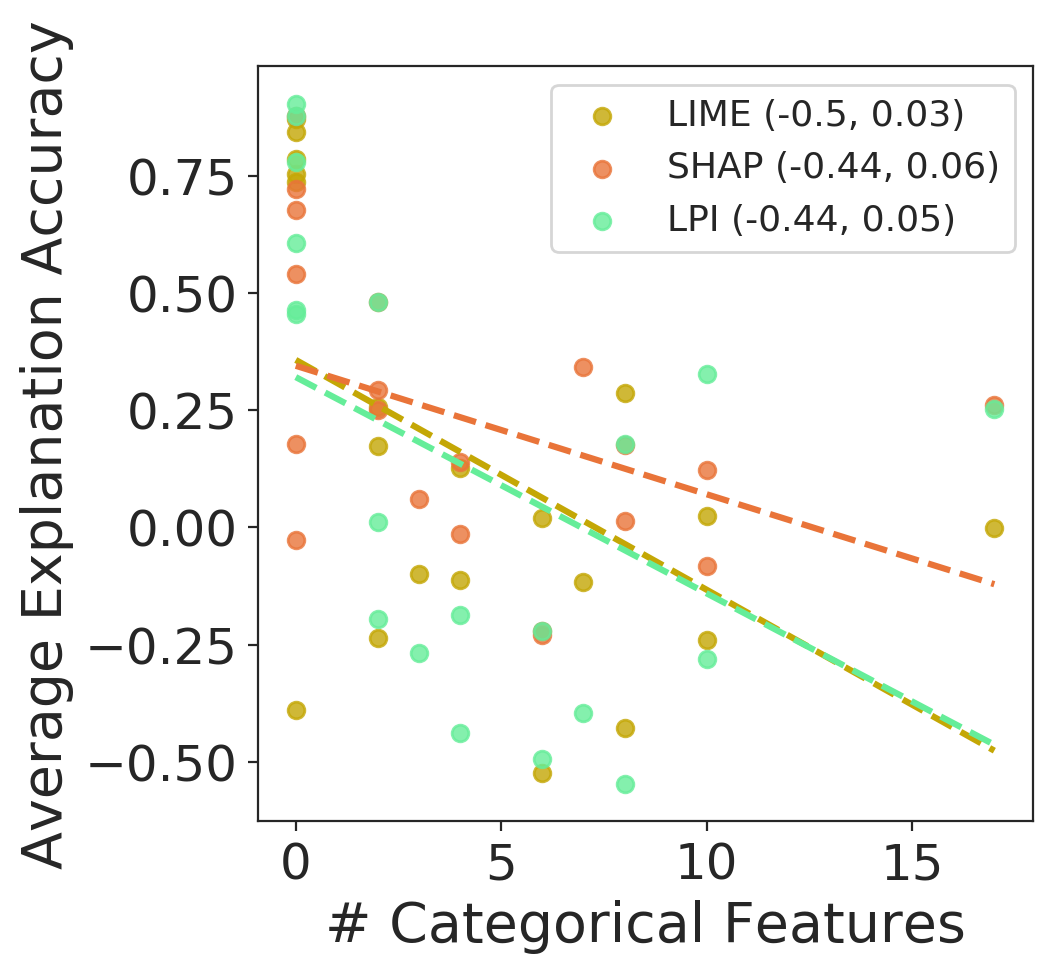

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)
sns.set_style("white")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)

#m_spearman_1 = m_spearman[m_spearman.loc[:, '# Cat. Feat'] > 0]

lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, '# Cat. Feat'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, '# Cat. Feat'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, '# Cat. Feat'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])

sns.regplot(x="# Cat. Feat", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str), color=exp_colors[0], ci=None, line_kws={'linestyle':'--'}, robust=True);
#ax.scatter(m_spearman_1.loc[:, '# Cat. Feat'], m_spearman_1.loc[:, 'LIME'], color=exp_colors[0])
#ax.plot(m_spearman_1.loc[:, '# Cat. Feat'], m_spearman_1.loc[:, 'LIME'], color=exp_colors[0], label='LIME ({})'.format(lime_coef_str))

sns.regplot(x="# Cat. Feat", y="SHAP", data=m_spearman, 
            ax=ax, label='SHAP ({})'.format(shap_coef_str), color=exp_colors[1], ci=None, line_kws={'linestyle':'--'}, robust=True);


sns.regplot(x="# Cat. Feat", y="LPI", data=m_spearman, 
            ax=ax, label='LPI ({})'.format(lpi_coef_str), color=exp_colors[2], ci=None, line_kws={'linestyle':'--'}, robust=True);
#ax.set(ylabel='Average Explanation Accuracy', xlabel='% Categorical Features')
ax.set(ylabel='Average Explanation Accuracy', xlabel='# Categorical Features')
ax.legend(fontsize=13)
plt.savefig('cat_feat_{}.eps'.format(model_name), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

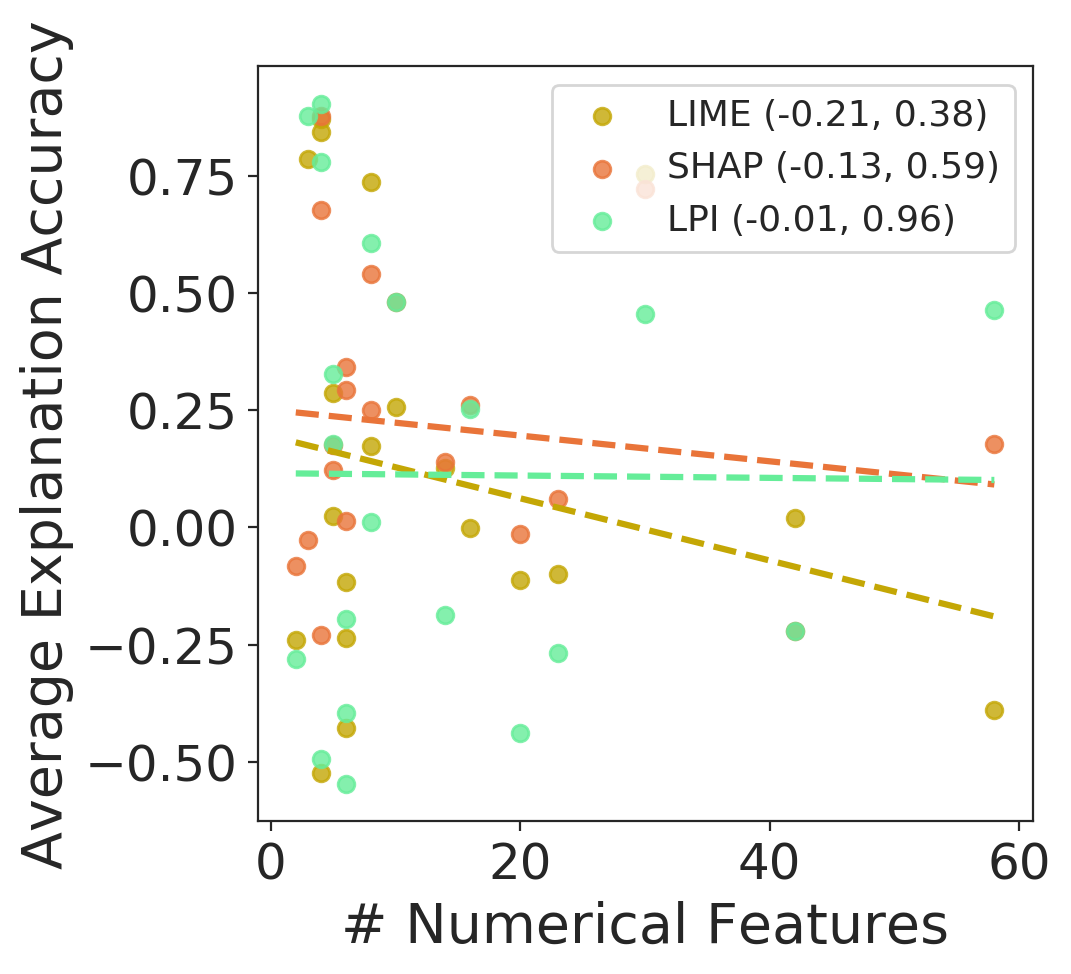

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)

lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, '# Num. Feat'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, '# Num. Feat'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, '# Num. Feat'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])


sns.regplot(x="# Num. Feat", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str),  color=exp_colors[0], ci=None, line_kws={'linestyle':'--'}, robust=True);

sns.regplot(x="# Num. Feat", y="SHAP", data=m_spearman, 
            ax=ax, label='SHAP ({})'.format(shap_coef_str), color=exp_colors[1], ci=None, line_kws={'linestyle':'--'}, robust=True);

sns.regplot(x="# Num. Feat", y="LPI", data=m_spearman, 
            ax=ax, label='LPI ({})'.format(lpi_coef_str), color=exp_colors[2], ci=None, line_kws={'linestyle':'--'}, robust=True);


ax.set(ylabel='Average Explanation Accuracy', xlabel='# Numerical Features')
ax.legend(fontsize=13)
plt.savefig('num_feat_{}.eps'.format(model_name), bbox_inches='tight')

lreg_gbayes = m_spearman.iloc[:, [3, 4, 5, -1, -2]].sort_values(by=['# Cat Features'])
lreg_gbayes.columns = ['LIME', 'SHAP', 'LPI', '# Cat Features', '# Features']
p = sns.pairplot(lreg_gbayes, kind="reg")
p

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

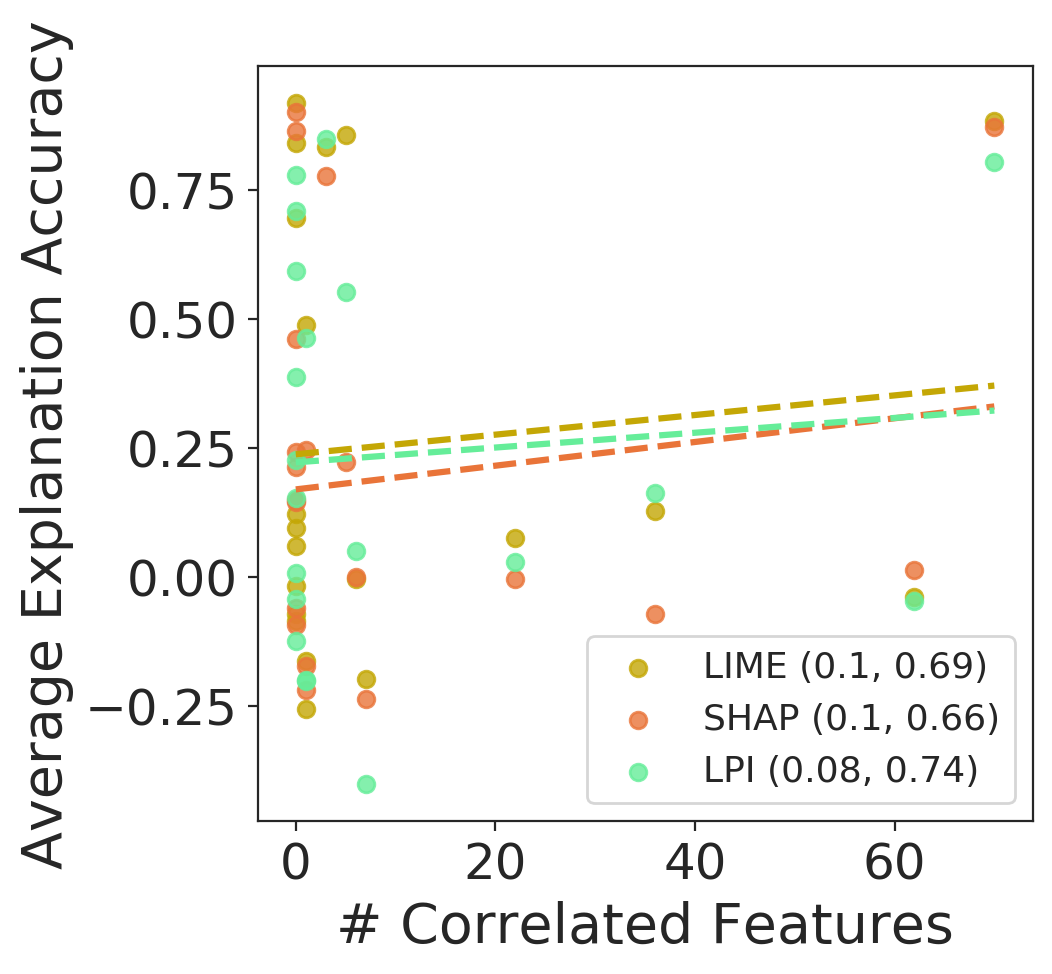

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)
sns.set_style("white")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)

#m_spearman_2 = m_spearman[m_spearman.loc[:, '# Corr. Feat'] > 0]

lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, '# Corr. Feat'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, '# Corr. Feat'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, '# Corr. Feat'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])

sns.regplot(x="# Corr. Feat", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str), color=exp_colors[0], ci=None, line_kws={'linestyle':'--'}, robust=True);
sns.regplot(x="# Corr. Feat", y="SHAP", data=m_spearman, 
            ax=ax, label='SHAP ({})'.format(shap_coef_str), color=exp_colors[1], ci=None, line_kws={'linestyle':'--'}, robust=True);
sns.regplot(x="# Corr. Feat", y="LPI", data=m_spearman, 
            ax=ax, label='LPI ({})'.format(lpi_coef_str), color=exp_colors[2], ci=None, line_kws={'linestyle':'--'}, robust=True);
ax.set(ylabel='Average Explanation Accuracy', xlabel='# Correlated Features')
ax.legend(fontsize=13)

plt.savefig('corr_feat_{}.eps'.format(model_name), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

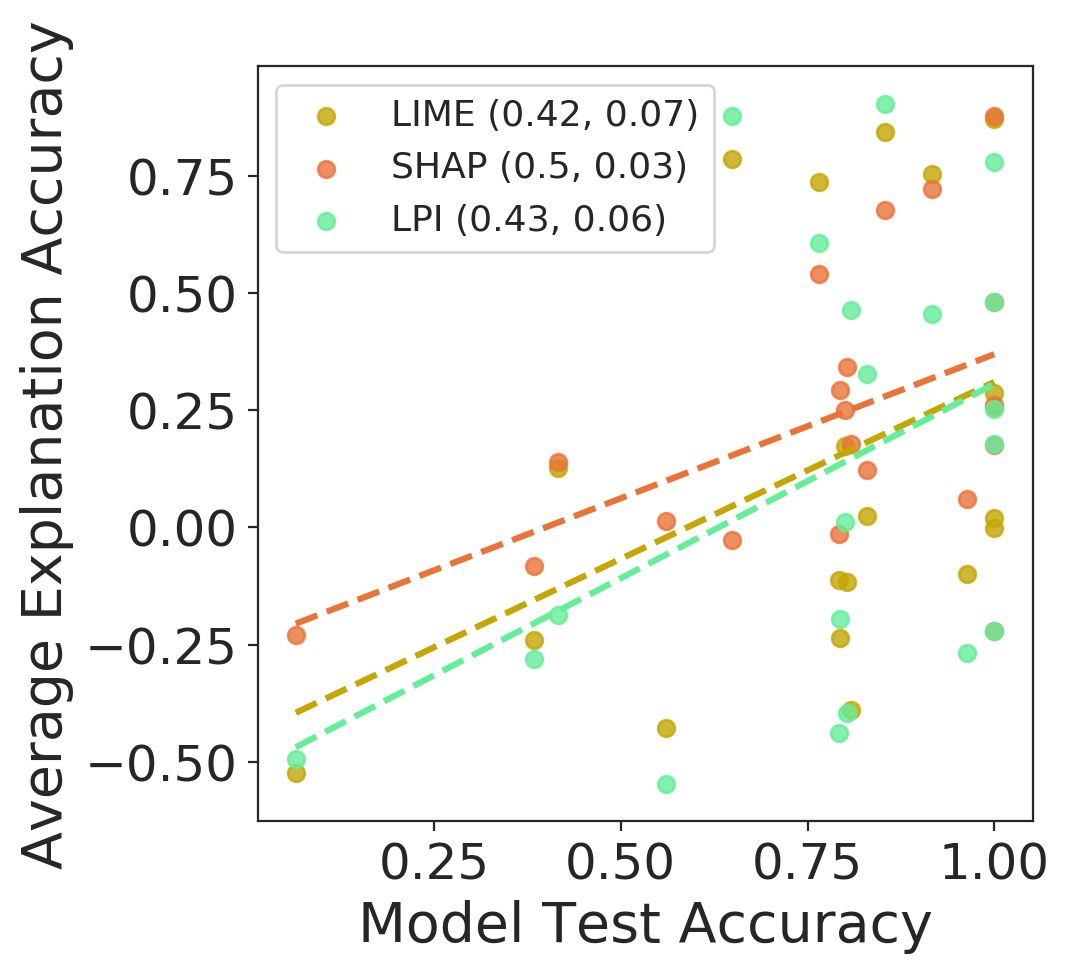

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)


lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, 'Accuracy'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, 'Accuracy'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, 'Accuracy'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])


sns.regplot(x="Accuracy", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str),  color=exp_colors[0], ci=None, line_kws={'linestyle':'--'});
sns.regplot(x="Accuracy", y="SHAP", data=m_spearman, ax=ax, 
            label='SHAP ({})'.format(shap_coef_str),  color=exp_colors[1], ci=None, line_kws={'linestyle':'--'});
sns.regplot(x="Accuracy", y="LPI", data=m_spearman, ax=ax, 
            label='LPI ({})'.format(lpi_coef_str),  color=exp_colors[2], ci=None, line_kws={'linestyle':'--'});
ax.set(ylabel='Average Explanation Accuracy', xlabel='Model Test Accuracy')
ax.legend(fontsize=13)
plt.savefig('model_accuracy_{}.eps'.format(model_name), bbox_inches='tight')

In [51]:
new_datasets = ['loan', 'breast_cancer', 'donor']
new_dataset_names = ['Loan', 'Breast Cancer', 'Donor']

In [52]:
def get_mean_measure_v1(_measures, models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    mean_measure = pd.DataFrame()

    for model in models:
        for exp_model in exp_models: 
            _measure = _measures[preproc][model][exp_model]
            mean_measure_res = []
            for j in range(len(new_datasets)):
                #print(_measure[j][measure_name])
                avg_measure = np.nanmean(_measure[j][measure_name])
                mean_measure_res.append(avg_measure)
            mean_measure[model, exp_model] =  mean_measure_res
            #mean_measure[exp_model] =  mean_measure_res
    mean_measure.index = new_datasets 
    
    mean_measure.index = new_dataset_names 
    #mean_measure = mean_measure.sort_index().round(3)
        
    #mean_measure['# Features'] = data_feat_len
    #mean_measure['# Cat Features'] = data_cat_feat_len
    #mean_measure['# Corr. Features'] = inner_corr
    
    #for model in models:
    #    if model == 'lreg':
    #        mean_measure['# Corr. Features (Output)'] = lreg_corr
    #    else: 
    #        mean_measure['# Corr. Features (Output)'] = gbayes_corr
    
    #mean_measure.loc['Average'] = mean_measure.mean()
    #mean_measure.loc['Standard Deviation'] = mean_measure.std()

    return mean_measure


In [53]:
measures_11 = pickle.load( open( "{}/exp_accuracy_v11.p".format(BASE_PATH), "rb" ) )
measures_12 = pickle.load( open( "{}/exp_accuracy_v12.p".format(BASE_PATH), "rb" ) )
measures_13 = pickle.load( open( "{}/exp_accuracy_v13.p".format(BASE_PATH), "rb" ) )

In [54]:
sample_1000 = get_mean_measure_v1(measures_13, ['lreg', 'gbayes'], 'standard', ['lime', 'shap'])
sample_2000 = get_mean_measure_v1(measures_11, ['lreg', 'gbayes'], 'standard', ['lime', 'shap'])
sample_5000 = get_mean_measure_v1(measures, ['lreg', 'gbayes'], 'standard', ['lime', 'shap'])
sample_7000 = get_mean_measure_v1(measures_12, ['lreg', 'gbayes'], 'standard', ['lime', 'shap'])

all_sample_data = [sample_1000, sample_2000, sample_5000, sample_7000]

In [55]:
d_names = sample_2000.index.values

In [56]:
all_sample_data

[               (lreg, lime)  (lreg, shap)  (gbayes, lime)  (gbayes, shap)
 Loan               0.486911     -0.219916        0.289284        0.175933
 Breast Cancer      0.880618      0.871964        0.736800        0.724734
 Donor              0.123504     -0.067118        0.028264       -0.221325,
                (lreg, lime)  (lreg, shap)  (gbayes, lime)  (gbayes, shap)
 Loan               0.486911     -0.219916        0.297568        0.175933
 Breast Cancer      0.879137      0.872452        0.755563        0.723124
 Donor              0.118329     -0.069289        0.018986       -0.221325,
                (lreg, lime)  (lreg, shap)  (gbayes, lime)  (gbayes, shap)
 Loan              -0.038509      0.013601       -0.111326       -0.013467
 Breast Cancer      0.882162      0.871415        0.753432        0.721602
 Donor              0.840952      0.862666        0.737619        0.541091,
                (lreg, lime)  (lreg, shap)  (gbayes, lime)  (gbayes, shap)
 Loan               0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


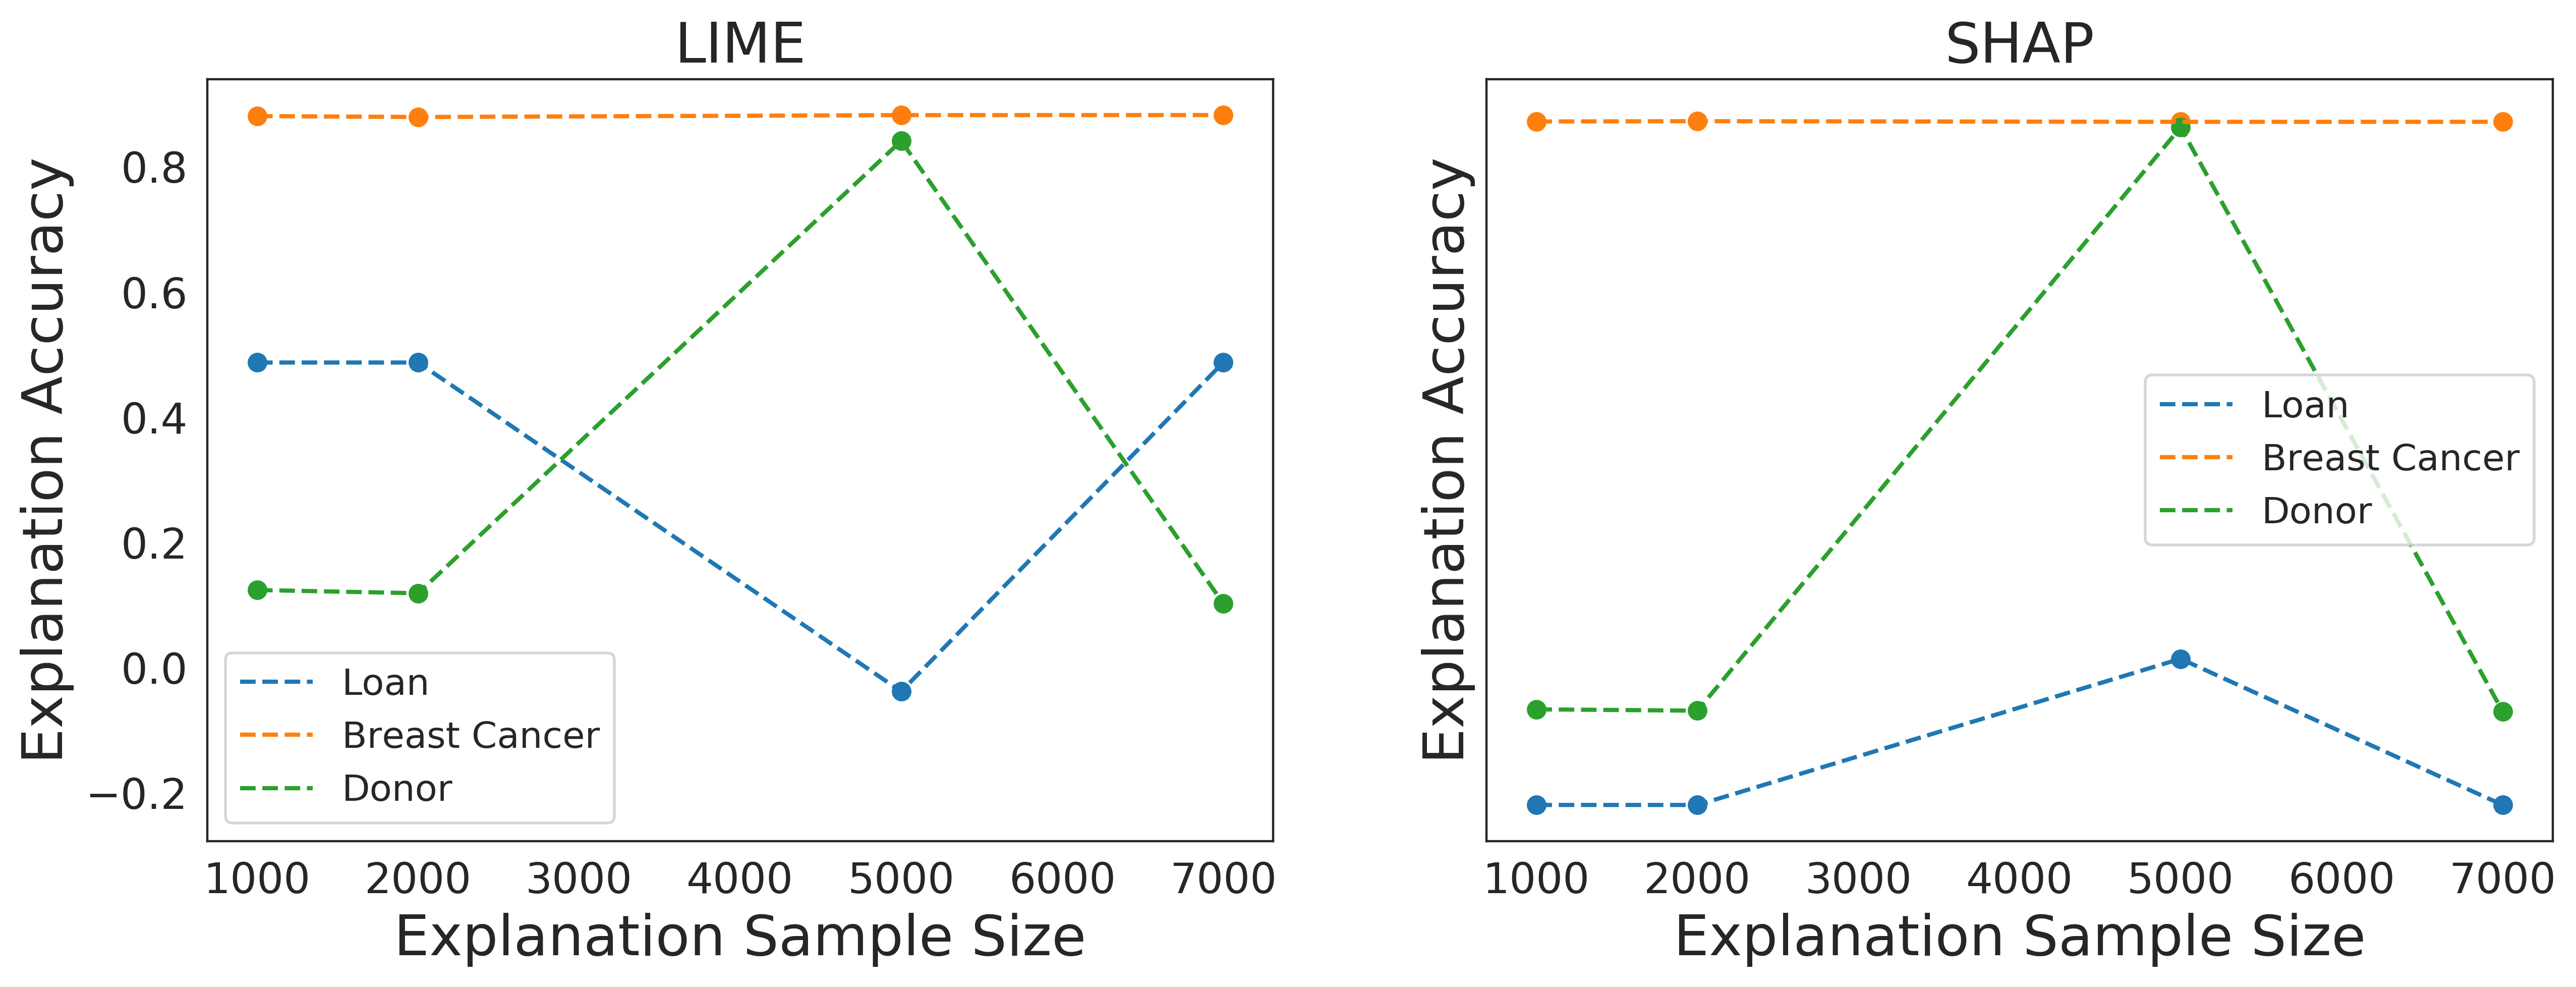

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=400, sharey=True)


exps = ['lime', 'shap']
exps_name = ['LIME', 'SHAP']

model_name = 'lreg'
for i in range(len(exps)):
    for d in new_dataset_names:
        data_val = []
        for a in all_sample_data:
            data_val.append(a[model_name, exps[i]][d])
        ax[i].plot([1000, 2000, 5000, 7000], data_val, label=d, linestyle='--')
        ax[i].scatter([1000, 2000, 5000, 7000], data_val, linestyle='-')
        ax[i].set_xlabel('Explanation Sample Size')
        ax[i].set_ylabel('Explanation Accuracy')
        ax[i].set_title(exps_name[i], fontsize=20)
        ax[i].xaxis.label.set_size(20)
        ax[i].yaxis.label.set_size(20)

        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(fontsize=13)
    #data_val.append(vals_)
plt.savefig('explanation_sample_lreg.eps')

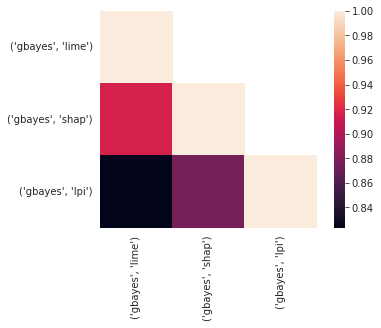

In [64]:
fig, ax = plt.subplots(1, 1)

m_spearman = get_mean_measure(['gbayes'],  'standard', ['lime', 'shap', 'lpi'],measure_name='norm')
#m_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
#                      '# Corr. Feat', '# Corr. Feat (Output)', 'Accuracy']

all_corr_values = m_spearman.corr('spearman')
lreg = m_spearman.iloc[:, 0:3].corr()
#lreg.columns = ['LIME', 'SHAP', 'LPI']
mask = np.triu(np.ones_like(lreg, dtype=bool), +1)
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)
ax.set_aspect("equal")

sns.heatmap(lreg, mask=mask, ax=ax)
#plt.savefig('./gbayes_corr.eps')
plt.show()

In [42]:
inner_corr

[0.007246376811594203,
 0.017241379310344827,
 0.0,
 0.0,
 0.08333333333333333,
 0.0,
 0.00030248033877797946,
 0.0,
 0.0,
 0.0,
 0.0,
 0.013846153846153847,
 0.00641025641025641,
 0.0,
 0.0008865248226950354,
 0.0032679738562091504,
 0.007575757575757576,
 0.0,
 0.0,
 0.0]

In [141]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], facecolor=color, linewidth=1.5)
    plt.setp(bp['medians'], color='black', linewidth=1.5)
    plt.setp(bp['fliers'], color=color, markerfacecolor=color, markeredgecolor='black', linewidth=1.5)

In [142]:
def get_exp_filter(preproc, model_name, exp_type, measure_name, filter_datasets):
    measures_info = pd.DataFrame(measures[preproc][model_name][exp_type]).loc[:, measure_name]
    #print(measures_info)
    measures_info.index = dataset_names
    measures_info = measures_info.iloc[measures_info.index.isin(filter_datasets)]
    measures_info.sort_index(axis=0, inplace=True)
    #print(measures_info)
    #print(measures_info)
    #for idx, val in measures_info.iteritems():
    #    print(idx, val)
    #    measures_info[idx] = np.array(val)[~np.isnan(np.array(val))]
    for d in filter_datasets:
        measures_info[d] = np.nan_to_num(measures_info[d])
    #measures_info = measures_info.replace(np.nan, 0)
    return measures_info

In [198]:
def get_std_measure(models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    std_measure = pd.DataFrame()

    for model in models:
        for exp_model in exp_models: 
            _measure = measures[preproc][model][exp_model]
            std_measure_res = []
            for j in range(len(datasets)):
                #print(_measure[j][measure_name])
                avg_measure = np.nanstd(_measure[j][measure_name])
                std_measure_res.append(avg_measure)
            std_measure[model, exp_model] =  std_measure_res
    std_measure.index = dataset_names 

    std_measure = std_measure.sort_index()
    #std_measure.loc['Average'] = std_measure.mean()
    #std_measure.loc['Standard Deviation'] = std_measure.std()

    return std_measure

In [199]:
model_name = 'lreg'
std_spearman_lreg = get_std_measure([model_name],  'standard', ['lime', 'shap', 'lpi'], measure_name='spearman_abs')
std_spearman_lreg.columns = ['LIME', 'SHAP', 'LPI']
std_spearman_lreg.loc[:, 'average'] = std_spearman_lreg.mean(axis=1)
large_std_lreg = list(std_spearman_lreg.sort_values(by='average', ascending=False).index[:10])


model_name = 'gbayes'
std_spearman_gbayes = get_std_measure([model_name],  'standard', ['lime', 'shap', 'lpi'], measure_name='spearman_abs')
std_spearman_gbayes.columns = ['LIME', 'SHAP', 'LPI']
std_spearman_gbayes.loc[:, 'average'] = std_spearman_gbayes.mean(axis=1)
large_std_gbayes = list(std_spearman_gbayes.sort_values(by='average', ascending=False).index[:10])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


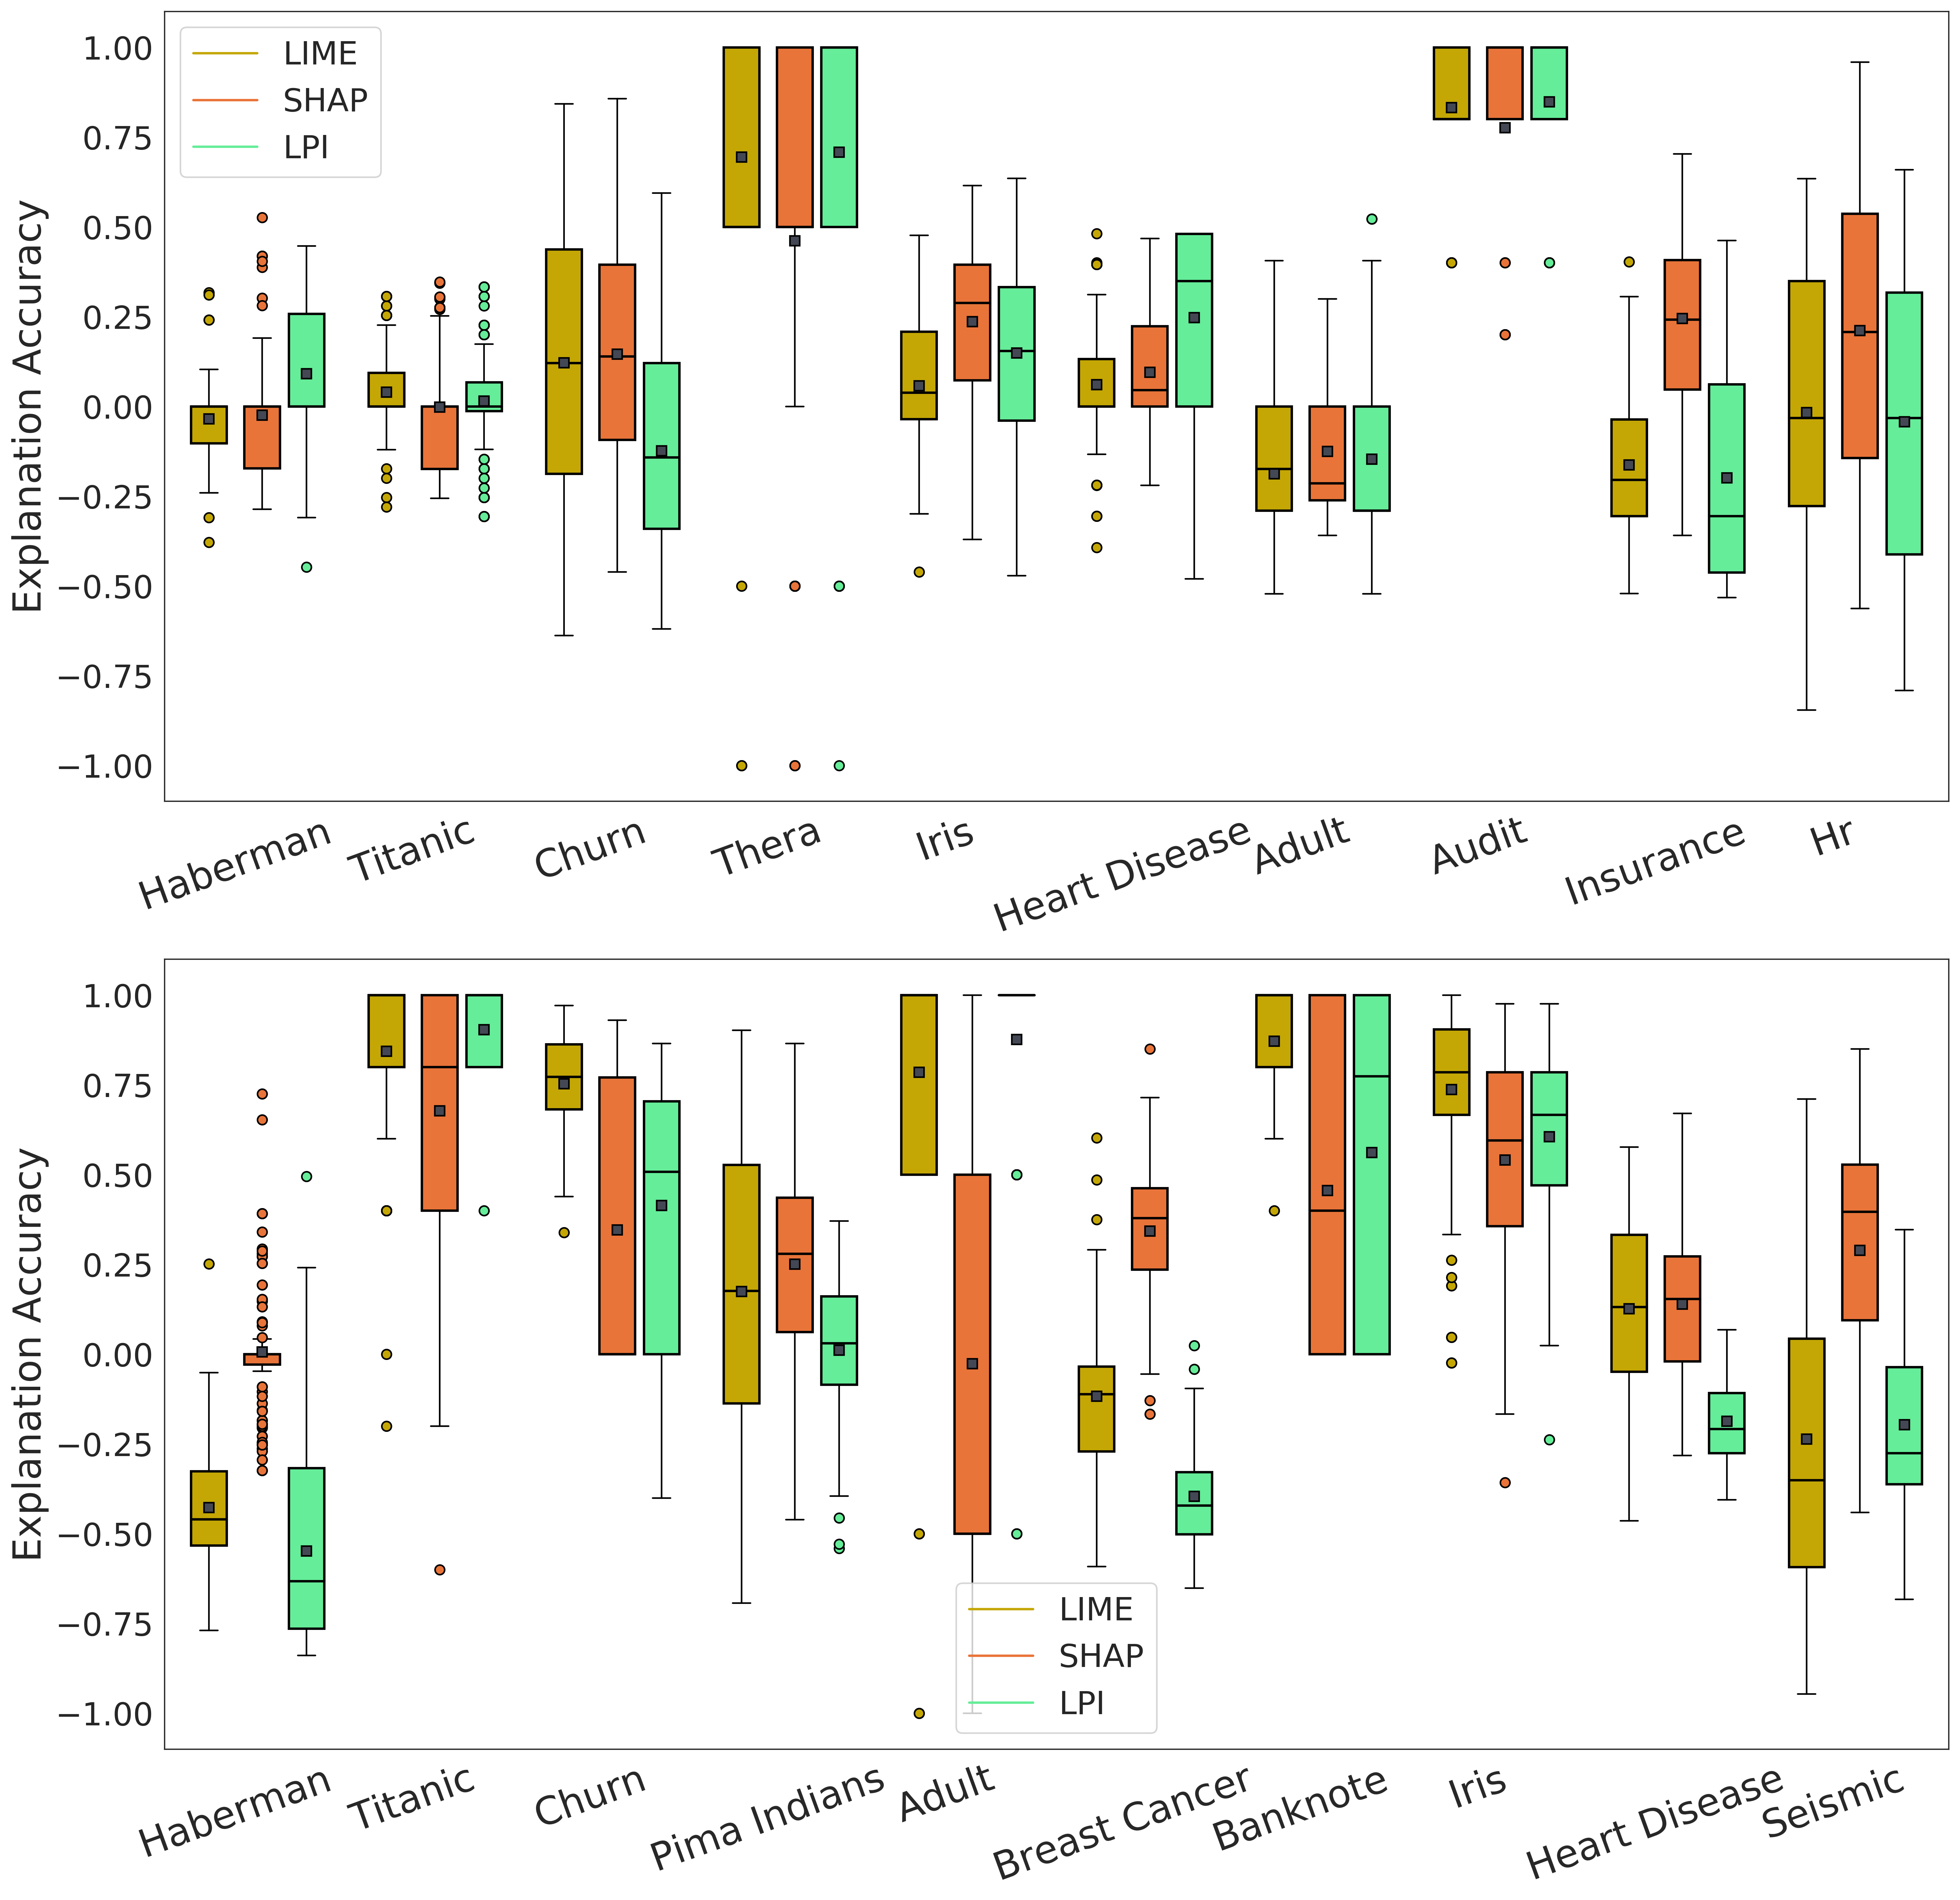

In [201]:
exp_colors = ['#C4A705', '#E97439', '#65ED99']
fig, ax = plt.subplots(2, 1, figsize=(20, 20), dpi=400)
ax = ax.ravel()

#filter_datasets = ['Breast Cancer', 'Pima Indians', 'Banknote', 'Iris', 'Haberman', 'Donors',  'Attrition', 'Spambase']
#filter_datasets = {'lreg': ['Donor', 'Adult', 'Thera', 'Insurance', 'Seismic', 'Titanic', 'Attrition', 'Audit', 'Banking'], 
#                   'gbayes': ['Donor', 'Adult', 'Thera', 'Insurance', 'Seismic', 'Titanic', 'Attrition', 'Audit', 'Banking']}

#filter_datasets = {'lreg': filter_datasets['lreg'], 
#                   'gbayes': filter_datasets['gbayes']}


filter_datasets = {'lreg': large_std_lreg, 'gbayes': large_std_gbayes}


preproc = 'standard'
flierprops = {'lime': dict(marker='o', markeredgecolor='#D7191C'),
              'shap': dict(marker='o', markeredgecolor='#2C7BB6'),
              'permute': dict(marker='o', markeredgecolor='#008000')}

i = 0
rank_dfs = pd.DataFrame()
measure_name = 'spearman_abs'
boxprops = dict(linestyle='-', linewidth=1.5)


for model_name in models:
    lime_exp_values = get_exp_filter(preproc, model_name, 'lime', measure_name, filter_datasets[model_name])
    bp_lime = ax[i].boxplot(lime_exp_values, positions=np.array(np.arange(lime_exp_values.shape[0]))*2.0-0.3, 
                         widths=0.4, boxprops=boxprops, showfliers=True, flierprops=flierprops['lime'], 
                            patch_artist=True, showmeans=True, 
                            meanprops={'marker':'s', "markerfacecolor":'#434854', "markeredgecolor":"black"})
    shap_exp_values = get_exp_filter(preproc, model_name, 'shap', measure_name, filter_datasets[model_name])
    bp_shap = ax[i].boxplot(shap_exp_values, positions=np.array(np.arange(shap_exp_values.shape[0]))*2.0+0.3, 
                         widths=0.4, boxprops=boxprops, showfliers=True, flierprops=flierprops['shap'], 
                            patch_artist=True, showmeans=True, meanprops={'marker':'s', "markerfacecolor":'#434854',
                                                                          "markeredgecolor":"black"})
    
    lpi_exp_values = get_exp_filter(preproc, model_name, 'lpi', measure_name, filter_datasets[model_name])
    bp_pi = ax[i].boxplot(lpi_exp_values, positions=np.array(np.arange(lpi_exp_values.shape[0]))*2.0+0.8, 
                       widths=0.4, boxprops=boxprops, showfliers=True, flierprops=flierprops['permute'], 
                          patch_artist=True, showmeans=True, 
                          meanprops={'marker':'s', "markerfacecolor":'#434854', "markeredgecolor":"black"})
        
    set_box_color(bp_lime,  exp_colors[0])
    set_box_color(bp_shap, exp_colors[1])
    set_box_color(bp_pi, exp_colors[2])

    ax[i].plot([], c=exp_colors[0], label='LIME')
    ax[i].plot([], c=exp_colors[1], label='SHAP')
    ax[i].plot([], c=exp_colors[2], label='LPI')
    
    ticks = filter_datasets[model_name]
    ax[i].set_xticks(np.arange(0, len(ticks) * 2, 2))
    ax[i].set_xticklabels(ticks, rotation=20, fontsize=24)
    ax[i].set_ylabel('Explanation Accuracy', fontsize=24)
    ax[i].yaxis.set_tick_params(labelsize=20)

    ax[i].legend(prop={'size': 20})    
    i+=1

plt.savefig("boxplot_lr_nb.eps", bbox_inches='tight')
plt.show()

In [46]:
from scipy.stats import friedmanchisquare
friedmanchisquare(m_spearman[('LIME')], m_spearman[('SHAP')], m_spearman[( 'LPI')]) 

FriedmanchisquareResult(statistic=1.727272727272748, pvalue=0.4216261054869992)

In [47]:
m_spearman_abs = get_mean_measure(['gbayes'],  'standard', ['lime', 'shap', 'lpi'], measure_name='spearman_abs')
m_spearman_abs.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Corr. Feat', '# Corr. Feat (Output)', 'Accuracy']

m_cosine = get_mean_measure(['gbayes'],  'standard', ['lime', 'shap', 'lpi'], measure_name='cosine')
m_cosine.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Corr. Feat', '# Corr. Feat (Output)', 'Accuracy']

m_norm = get_mean_measure(['gbayes'],  'standard', ['lime', 'shap', 'lpi'], measure_name='norm')
m_norm.columns = ['LIME', 'SHAP', 'LPI', '# Num. Feat', '# Cat. Feat', 
                      '# Corr. Feat', '# Corr. Feat (Output)', 'Accuracy']


In [48]:
friedmanchisquare(m_spearman[('LIME')], m_spearman[('SHAP')], m_spearman[( 'LPI')]) 

FriedmanchisquareResult(statistic=1.727272727272748, pvalue=0.4216261054869992)

In [49]:
friedmanchisquare(m_cosine[('LIME')], m_cosine[('SHAP')], m_cosine[( 'LPI')]) 

FriedmanchisquareResult(statistic=12.068965517241384, pvalue=0.002394734863026061)

In [50]:
friedmanchisquare(m_spearman[('LIME')], m_spearman[('SHAP')], m_spearman[( 'LPI')]) 

FriedmanchisquareResult(statistic=1.727272727272748, pvalue=0.4216261054869992)

In [1]:
import Orange
names = ['LIME', 'SHAP', 'LPI' ]
#lreg_mean_rank = m_spear man.iloc[:, 0:3].rank(axis=1, ascending=False).mean()
ranked_stuff = m_cosine.iloc[:, 0:3].rank(axis=1, ascending=False).mean()
cd = Orange.evaluation.compute_CD(ranked_stuff, 20) #tested on 30 datasets
Orange.evaluation.graph_ranks(lreg_mean_rank, names, cd=cd, width=6, textspace=1.5)
plt.show()

ModuleNotFoundError: No module named 'Orange'